In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU: Tesla T4


In [5]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.metrics import accuracy_score, f1_score


In [6]:
DATA_DIR = "/kaggle/input/aptos2019-blindness-detection"

train_csv = os.path.join(DATA_DIR, "train.csv")
img_dir = os.path.join(DATA_DIR, "train_images")

df = pd.read_csv(train_csv)
print(df.head())
print("Total samples:", len(df))


        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
Total samples: 3662


In [18]:
class DRDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, "id_code"]
        label = self.df.loc[idx, "diagnosis"]
        img_path = os.path.join(self.img_dir, img_id + ".png")

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)
model = model.to(device)

model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
dataset = DRDataset(df.sample(32), img_dir, transform)
loader = DataLoader(dataset, batch_size=8, shuffle=False)

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Macro F1:", f1_score(all_labels, all_preds, average="macro"))


Accuracy: 0.34375
Macro F1: 0.11578947368421053


In [46]:
from torchvision.models.feature_extraction import create_feature_extractor

target_layer = "layer4"
extractor = create_feature_extractor(model, return_nodes={target_layer: "feat"})

def grad_cam(image, class_idx):
    image = image.unsqueeze(0).to(device)
    image.requires_grad = True

    feats = extractor(image)["feat"]
    output = model(image)
    score = output[0, class_idx]

    model.zero_grad()
    score.backward()

    gradients = image.grad.abs().mean(dim=(2,3)).cpu().numpy()[0]
    return gradients


In [33]:
torch.save(model.state_dict(), "dr_resnet50.pth")


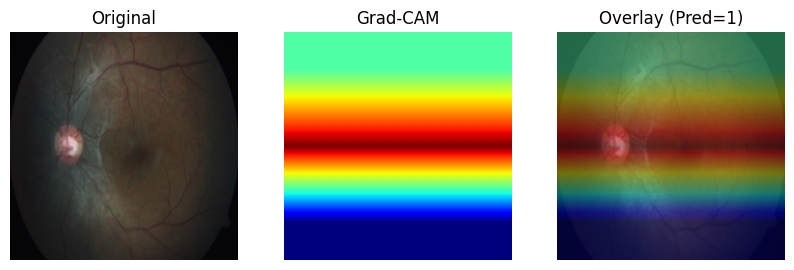

In [47]:
import cv2

# pick one sample
sample_df = df.sample(1).reset_index(drop=True)
img_id = sample_df.loc[0, "id_code"]
true_label = sample_df.loc[0, "diagnosis"]

img_path = os.path.join(img_dir, img_id + ".png")
raw_img = Image.open(img_path).convert("RGB")

input_tensor = transform(raw_img)
pred_class = torch.argmax(model(input_tensor.unsqueeze(0).to(device)), dim=1).item()

cam = grad_cam(input_tensor, pred_class)

# Resize CAM to image size
cam = cv2.resize(cam, (224, 224))
cam = (cam - cam.min()) / (cam.max() - cam.min())

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(raw_img.resize((224,224)))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM")
plt.imshow(cam, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Overlay (Pred={pred_class})")
plt.imshow(raw_img.resize((224,224)))
plt.imshow(cam, cmap="jet", alpha=0.4)
plt.axis("off")

plt.show()
